# Train tabular model/ text model/ new tabular+text model

From https://nbviewer.jupyter.org/gist/joshfp/b62b76eae95e6863cb511997b5a63118/5.full-deep-learning.ipynb

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn.model_selection import KFold

In [3]:
from fastai.callbacks.tracker import *
from fastai.text import *
from fastai.tabular import *

In [4]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [5]:
mercari_path = Path('data/')

In [6]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.7.1
fastai        : 1.0.51
fastprogress  : 0.1.19
torch         : 1.0.0
nvidia driver : 410.104
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8116MB | GeForce GTX 1080

=== Environment === 
platform      : Linux-4.15.0-47-generic-x86_64-with-debian-stretch-sid
distro        : #50~16.04.1-Ubuntu SMP Fri Mar 15 16:06:21 UTC 2019
conda env     : python37
python        : /home/quantran/anaconda3/envs/python37/bin/python
sys.path      : 
/home/quantran/kwon/kaggle/mercari
/home/quantran/anaconda3/envs/python37/lib/python37.zip
/home/quantran/anaconda3/envs/python37/lib/python3.7
/home/quantran/anaconda3/envs/python37/lib/python3.7/lib-dynload
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/IPython/extensions
/home/quantran/.ipython
```

Please make sure to include 

# Prepare data

In [7]:
def preprocess_text_cols(df: pd.DataFrame) -> pd.DataFrame:
  
    df['category_name'] = df['category_name'].fillna('//')
    df['category1'] = df['category_name'].apply(lambda x : x.split('/')[0].strip())
    df.loc[df.category1=='','category1']= np.NaN
    df['category2'] = df['category_name'].apply(lambda x : x.split('/')[1].strip())
    df.loc[df.category2=='','category2']= np.NaN
    df['category3'] = df['category_name'].apply(lambda x : x.split('/')[2].strip())
    df.loc[df.category3=='','category3']= np.NaN
    df['category_name'] = df['category_name'].apply( lambda x : ' '.join( x.split('/') ).strip() )
    df.loc[df.category_name=='','category_name']= 'No category' # let this info in when concatenating text for RNN
    
    df_bn_fillna = df['brand_name'].fillna('No brand')
    df['text'] = (df['name'].fillna('No name') + '. ' + df_bn_fillna + '. ' + 
                  df['category_name'] + '. ' + df['item_description'].fillna('No description'))
    return df[['category1','category2','category3','brand_name', 'text', 'shipping', 'item_condition_id','price']]

def preprocess_all(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price
    
    test = pd.read_table(mercari_path/'test_stg2.tsv').drop('test_id',axis=1)
    test['price'] = np.NAN
    train = train[train['price'] > 0].reset_index(drop=True)
    all_df = pd.concat([train,test],axis=0).reset_index(drop=True)
    del train
    del test
    gc.collect()

    all_df = preprocess_text_cols(all_df)
    train_df = all_df[~all_df.price.isnull()]
    test_df = all_df[all_df.price.isnull()]
    del all_df
    gc.collect()
    
    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train_df = train_df.loc[sample].reset_index(drop=True)
        
    test_df= test_df.drop('price',axis=1)    
    return train_df,test_df

def preprocess_train(sample=None):
    train = pd.read_table(mercari_path/'train.tsv').drop('train_id',axis=1)
    price = train.price.values
    train=train.drop('price',axis=1)
    train['price']=price

    if sample:
        np.random.seed(42)
        sample = np.random.permutation(sample)
        train = train.loc[sample].reset_index(drop=True)

    train = preprocess_text_cols(train)

    return train
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [8]:
n=1482535 # train shape

In [9]:
gc.collect()

7

In [10]:
train_df,test_df = preprocess_all(int(0.02*n))

train_df.shape,test_df.shape

((29650, 8), (3460725, 7))

In [36]:
# train_df = preprocess_train()
# train_df.shape

(1482535, 8)

In [11]:
train_df.columns

Index(['category1', 'category2', 'category3', 'brand_name', 'text', 'shipping',
       'item_condition_id', 'price'],
      dtype='object')

In [12]:
train_df.price = np.log1p(train_df['price']) # Metric for this is RMSLE, we log them so we can use MSE in NN

In [13]:
train_df.head()

,category1,category2,category3,brand_name,text,shipping,item_condition_id,price
0,Beauty,Makeup,Face,NaN,Primer & Brush Duo. No brand. Beauty Makeup Fa...,0,2,2.833213
1,Women,Dresses,"Above Knee, Mini",Bebe,Bebe black feather dress. Bebe. Women Dresses ...,0,2,3.555348
2,Women,Athletic Apparel,Jackets,NaN,For Kayla-do not buy. No brand. Women Athletic...,1,1,3.258097
3,Vintage & Collectibles,Accessories,Keychain,NaN,Rhinestone choker & pom pom keychain. No brand...,1,1,2.397895
4,Beauty,Makeup,Eyes,NaN,FREE SHP GREEN CONTAC LENSES. No brand. Beauty...,1,1,2.302585


In [14]:
for i in range(4):
    print(train_df.text[i])
    print('-'*20)

Primer & Brush Duo. No brand. Beauty Makeup Face. Younique face and eye primer : used once Brush: never used
--------------------
Bebe black feather dress. Bebe. Women Dresses Above Knee, Mini. Bebe black feather dress strapless around the neck decorative front bejeweled bow tie in the back satin beautiful dress like new no flaws size extra small women's
--------------------
For Kayla-do not buy. No brand. Women Athletic Apparel Jackets. New with tags and long sleeve. No free shipping and firm on price. Also have available in a size medium. No free shipping and firm on price.
--------------------
Rhinestone choker & pom pom keychain. No brand. Vintage & Collectibles Accessories Keychain. 1x rhinestone choker ( handmade) 1x pink pom pom keychain Brand new I ship fast
--------------------


In [15]:
cat_names=['category1','category2','category3','brand_name','shipping']
cont_names= list(set(train_df.columns) - set(cat_names) - {'price','text'})
print(f'# of continuous feas: {len(cont_names)}')
print(f'# of categorical feas: {len(cat_names)}')
dep_var = 'price'
procs = [FillMissing,Categorify, Normalize]

txt_cols=['text']

len(cat_names) + len(cont_names) + 2 == train_df.shape[1]

# of continuous feas: 1
# of categorical feas: 5


True

In [16]:
train_idxs,val_idxs = get_val_idxs(train_df,n_splits=20)
# train_idxs,val_idxs = get_val_idxs(train_df,n_splits=5)
train_idxs,val_idxs
train_idxs.shape,val_idxs.shape

(array([    0,     1,     2,     3, ..., 29646, 29647, 29648, 29649]),
 array([    6,    34,    92,    96, ..., 29586, 29597, 29634, 29642]))

((28167,), (1483,))

In [17]:
def get_tab_databunch(train_df,bs=100,val_idxs=val_idxs,path = mercari_path):
    return (TabularList.from_df(train_df, cat_names, cont_names, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
#                             .add_test(TabularTextList.from_df(test_df, cat_names, cont_names, txt_cols,path=path))
                            .databunch(bs=bs))

In [18]:
def get_text_databunch(train_df,bs=100,val_idxs=val_idxs,path = mercari_path):
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    return (TextList.from_df(train_df, cols = txt_cols[0], vocab=data_lm.vocab, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
                            .databunch(bs=bs))

In [20]:
# def get_tabulartext_databunch(bs=100,val_idxs=val_idxs,path=mercari_path):
#     data_lm = load_data(path, 'data_lm.pkl', bs=bs)
#     collate_fn = partial(mixed_tabular_pad_collate, pad_idx=1, pad_first=True)
#     reset_seed()
#     return (TabularTextList.from_df(train_df, cat_names, cont_names, txt_cols, vocab=data_lm.vocab, procs=procs, path=path)
#                             .split_by_idx(val_idxs)
#                             .label_from_df(cols=dep_var)
# #                             .add_test(TabularTextList.from_df(test_df, cat_names, cont_names, txt_cols,path=path))
#                             .databunch(bs=bs,collate_fn=collate_fn, no_check=False))

In [19]:
def get_tabular_learner(data,params,seed=42):
    return tabular_learner(data,metrics=[root_mean_squared_error],**params)

def get_text_learner(data,params,seed=42):
    encoder_name = 'bs60-awdlstm-enc-stage2'
    learn = text_classifier_learner(data,AWD_LSTM,metrics=root_mean_squared_error,**params)
    learn.load_encoder(encoder_name)
    return learn.to_fp32()

In [23]:
# encoder_name = 'bs60-awdlstm-enc-stage2'
# def get_tabtext_lr_find(data,params,seed=42):
#     reset_seed(seed)
#     learn_lf = tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],**params).to_fp16()
#     learn_lf.load_encoder(encoder_name)
#     return learn_lf.to_fp32()

# def get_tabulartext_learner(data,params,seed=42):
#     reset_seed(seed)
#     learn= tabtext_learner(data,AWD_LSTM,metrics=[root_mean_squared_error],
#                                callback_fns=[partial(SaveModelCallback, monitor='root_mean_squared_error',mode='min',every='improvement',name='best_nn')],
#                                **params).to_fp16() # because the language model is trained in fp16
#     learn.load_encoder(encoder_name)
#     return learn.to_fp32()

# Get databunch

In [45]:
tab_db = get_tab_databunch(train_df[cat_names + cont_names+ [dep_var]])

In [19]:
text_db = get_text_databunch(train_df[txt_cols +[dep_var]])

In [26]:
tab_db.show_batch()

category1,category2,category3,brand_name,shipping,item_condition_id,target
Beauty,Makeup,Makeup Palettes,#na#,1,-1.0001,2.1972246
Kids,Boys 2T-5T,Bottoms,#na#,0,1.2049,2.3978953
Women,Sweaters,Crewneck,PINK,1,1.2049,3.2580965
Men,Shoes,Athletic,Jordan,0,0.1024,5.332719
Beauty,Makeup,Face,L'Oreal,1,-1.0001,2.5649493


In [20]:
text_db.show_batch()

text,target
"xxbos xxmaj pink xxmaj samsung xxmaj galaxy xxup s8 xxmaj plus xxmaj case . xxmaj no brand . xxmaj electronics xxmaj cell xxmaj phones & xxmaj accessories xxmaj cases , xxmaj covers & xxmaj skins . xxmaj brand xxup new , xxmaj high quality xxmaj durable case . * * * xxmaj buy xxmaj today , xxmaj ship xxmaj today * * * xxmaj shipping takes 3 - 5 days",2.8332133
"xxbos xxmaj minnesota xxmaj vikings iphone 7 rubber case . xxmaj no brand . xxmaj sports & xxmaj outdoors xxmaj fan xxmaj shop xxup nfl . xxmaj brand xxup new , xxmaj high quality xxmaj durable rubber case . * * * xxmaj buy xxmaj today , xxmaj ship xxmaj today * * * xxmaj shipping takes 3 - 5 days with tracking # . xxrep 5 { . xxup",2.7080503
xxbos xxup storybook xxup cosmetics xxup wand xxup brushes . xxmaj no brand . xxmaj beauty xxmaj tools & xxmaj accessories xxmaj makeup xxmaj brushes & xxmaj tools . xxup brand xxup new xxup authentic xxup original xxup storybook xxup cosmetics ( 2 ) xxup wand xxup brushes xxup with xxup authentic xxup storybook xxup cosmetics xxup wand xxup brush xxup bag .. xxup this xxup listing xxup only xxup,3.0910425
"xxbos xxup hello xxup kitty xxup water xxup bottle & 2 xxup touch xxup lamps . xxmaj no brand . xxmaj handmade xxmaj glass xxmaj bottles . xxup brand xxup new xxup water xxup bottle & 2 xxup touch xxup sensor xxup lamps xxup with xxup hello xxup kitty xxup decals xxup by : xxup maya . xxup the xxup water xxup bottle xxup is xxup tritan xxup brand ,",3.1354942
"xxbos xxup 3xl xxup beige xxup waist xxup cincher . xxmaj no brand . xxmaj handmade xxmaj clothing xxmaj corset . 100 % xxup new xxup and xxup hight xxup quality xxup waist xxup cincher xxup shapes xxup the xxup tummy & xxup defines xxup your xxup waistline , xxup higher xxup rise xxup to xxup provide xxup optimal xxup coverage xxup for xxup every xxup day xxup wear .",2.4849067


# Train tabular

In [57]:
params={
    'layers':[500,400,200],
#     'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}

In [58]:
tab_learner = get_tabular_learner(tab_db,params)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


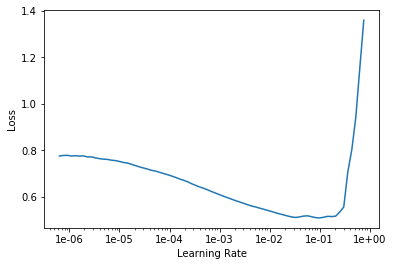

In [59]:
tab_learner.lr_find()
tab_learner.recorder.plot()

In [31]:
params={
    'layers':[500,200],
#     'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}
tab_learner = get_tabular_learner(tab_db,params)
tab_learner.fit_one_cycle(5,max_lr = 2e-03,pct_start=.3,moms=(0.95, 0.85))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.388644,0.360133,0.596372,00:01
1,0.353052,0.356356,0.594344,00:01
2,0.337223,0.326131,0.568739,00:01
3,0.297957,0.320199,0.562867,00:01
4,0.284083,0.324008,0.566056,00:01


In [60]:
# # train on full dataset
# params={
#     'layers':[500,400,200],
# #     'ps': [0.001,0,0],
#     'emb_drop': 0.,
#     'y_range': [0,6],
#     'use_bn': True,    
# }
# tab_learner = get_tabular_learner(tab_db,params,)
# tab_learner.fit_one_cycle(6,max_lr = 1e-02,pct_start=.3,moms=(0.95, 0.85))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.316520,0.322360,0.567687,00:17
1,0.308784,0.312987,0.559367,00:17
2,0.305537,0.305977,0.553064,00:16
3,0.299920,0.303430,0.550750,00:16
4,0.295662,0.301751,0.549227,00:17
5,0.293086,0.301080,0.548616,00:16


# Train text

In [21]:
text_db = get_text_databunch(train_df[txt_cols +[dep_var]])

In [26]:
params={
    'lin_ftrs':[1000],
#     'ps': [0.001,0,0],
    'bptt':100,
    'max_len':20*70,
    'drop_mult': 1., 
#     'y_range': [0,6], # there is no y_range in text_classfier_learner
#     'use_bn': True,    
}

In [27]:
text_learner = get_text_learner(text_db,params)

In [189]:
# bn_drop_lin(params['lin_ftrs'][1],1)

# # fix some weird bug when doing regression with text_learner
# text_learner = get_text_learner(text_db,params)
# text_learner.model[1].layers = nn.Sequential( *(list(text_learner.model[1].layers) + bn_drop_lin(params['lin_ftrs'][1],1)) ).cuda()

[BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=200, out_features=1, bias=True)]

In [195]:
# text_learner.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


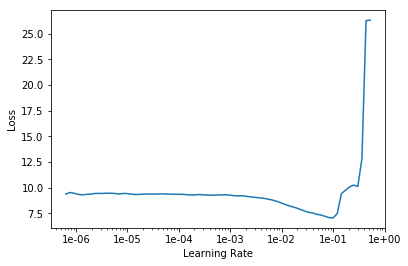

In [29]:
text_learner.lr_find()
text_learner.recorder.plot(skip_end=1)

In [30]:
text_learner.fit_one_cycle(5,max_lr = 1e-02,pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.699812,0.475136,0.686352,00:27
1,0.577503,0.560678,0.745181,00:28
2,0.515830,0.392125,0.622882,00:29
3,0.487941,0.371341,0.606690,00:26
4,0.496415,0.373503,0.608344,00:30


In [32]:
# text_learner.save('tmp1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


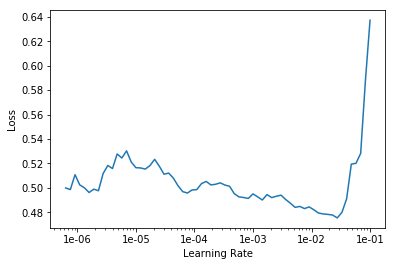

In [33]:
_=text_learner.load('tmp1')
text_learner.freeze_to(-2)
text_learner.lr_find()
text_learner.recorder.plot()

In [38]:
_=text_learner.load('tmp1')
text_learner.freeze_to(-2)

In [39]:
text_learner.fit_one_cycle(2,max_lr = slice(1e-05,1e-03),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.477718,0.365917,0.602141,00:34
1,0.491508,0.361138,0.598394,00:33


In [40]:
# text_learner.save('tmp2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


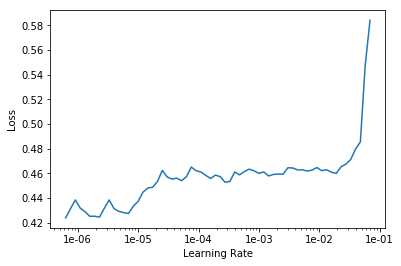

In [43]:
_=text_learner.load('tmp2')
text_learner.freeze_to(-3)
text_learner.lr_find()
text_learner.recorder.plot()

In [48]:
_=text_learner.load('tmp2')
text_learner.freeze_to(-3)

text_learner.fit_one_cycle(2,max_lr = slice(1e-06,8e-05),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.477855,0.361182,0.598372,00:55
1,0.475571,0.361878,0.598912,01:01


In [49]:
# text_learner.save('tmp3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


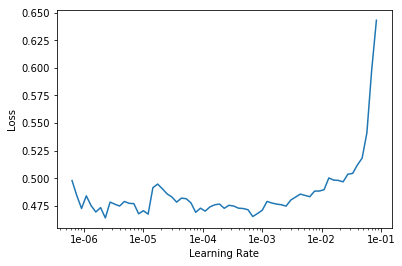

In [53]:
_=text_learner.load('tmp3')
text_learner.unfreeze()
text_learner.lr_find()
text_learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


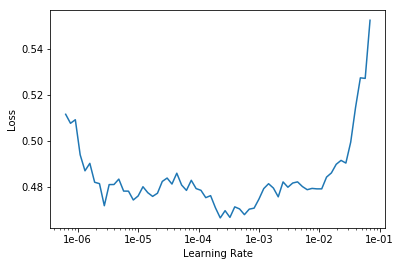

In [52]:
_=text_learner.load('tmp3')
text_learner.unfreeze()
text_learner.lr_find()
text_learner.recorder.plot()

In [54]:
_=text_learner.load('tmp3')
text_learner.unfreeze()

text_learner.fit_one_cycle(5,max_lr = slice(1e-06,8e-05),pct_start=0.3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.503838,0.360852,0.598226,01:19
1,0.471973,0.366016,0.602466,01:14
2,0.479939,0.360503,0.598051,01:13
3,0.476493,0.363892,0.600721,01:23
4,0.467288,0.361779,0.599025,01:21


# Combining tabular and text together

In [28]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1,self.x2,self.y = x1,x2,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return (self.x1[i], self.x2[i]), self.y[i]
    
def my_collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x)) # x1 would be (cat,cont), x2 would be numericalized ids for text
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y

class ConcatModel(nn.Module):
    def __init__(self, mod_tab, mod_nlp, layers, drops): 
        super().__init__()
        self.mod_tab = mod_tab
        self.mod_nlp = mod_nlp
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.mod_tab(*x[0])
        x_nlp = self.mod_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)    

In [23]:
tab_db = get_tab_databunch(train_df[cat_names + cont_names+ [dep_var]])

text_db = get_text_databunch(train_df[txt_cols +[dep_var]])

In [27]:
params={
    'layers':[500],
#     'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
}
tab_learner = get_tabular_learner(tab_db,params)

tab_learner.model.layers = tab_learner.model.layers[:-2]

In [33]:
tab_learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(11, 6)
    (1): Embedding(110, 22)
    (2): Embedding(590, 57)
    (3): Embedding(1201, 85)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=174, out_features=500, bias=True)
    (1): ReLU(inplace)
  )
)

In [58]:
params={
#     'lin_ftrs':[1000],
#     'ps': [0.001,0,0],
    'bptt':70,
    'max_len':20*70,
    'drop_mult': 1., 
#     'y_range': [0,6], # there is no y_range in text_classfier_learner
#     'use_bn': True,    
}

text_learner = get_text_learner(text_db,params)

In [60]:
text_learner.model[-1].layers =text_learner.model[-1].layers[:-3] 
text_learner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(33781, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(33781, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
    )
  )
)

In [61]:
train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)

In [63]:
bs = 70
train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))

In [64]:
train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=my_collate, path=mercari_path)

In [65]:
(x1,x2),y = next(iter(data.train_dl))
print(f'Shape tabular batch (cats/cont): {x1[0].shape} / {x1[1].shape}')
print(f'Shape nlp batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape tabular batch (cats/cont): torch.Size([35, 5]) / torch.Size([35, 1])
Shape nlp batch: torch.Size([35, 388])
Shape dependent var: torch.Size([35])


In [67]:
lin_layers = [500+50, 1]
ps = [0.]
model = ConcatModel(tab_learner.model, text_learner.model, lin_layers, ps)
model

ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(11, 6)
      (1): Embedding(110, 22)
      (2): Embedding(590, 57)
      (3): Embedding(1201, 85)
      (4): Embedding(3, 3)
    )
    (emb_drop): Dropout(p=0.0)
    (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=174, out_features=500, bias=True)
      (1): ReLU(inplace)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(33781, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(33781, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1150, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1150, 1150, batch_first=True)
          )
          (2): WeightDropout(
            (module): LSTM(1150, 40

In [68]:
loss_func = MSELossFlat()
layer_groups = [nn.Sequential(*flatten_model(text_learner.layer_groups[0])),
                nn.Sequential(*flatten_model(text_learner.layer_groups[1])),
                nn.Sequential(*flatten_model(text_learner.layer_groups[2])),
                nn.Sequential(*flatten_model(text_learner.layer_groups[3])),
                nn.Sequential(*(flatten_model(text_learner.layer_groups[4]) + 
                                flatten_model(model.mod_tab) +
                                flatten_model(model.layers)))] 
learn = Learner(data, model, loss_func=loss_func, metrics=root_mean_squared_error, layer_groups=layer_groups)

In [29]:
def get_data_v2(bs=70,path= mercari_path):
    
    tab_db = get_tab_databunch(train_df[cat_names + cont_names+ [dep_var]])
    text_db = get_text_databunch(train_df[txt_cols +[dep_var]])
    
    train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
    valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)
    
    train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))

    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=my_collate, path=path)
    return data,tab_db,text_db

In [30]:
def get_learner_v2(data,tab_db,text_db):
    params={
    'layers':[500],
#     'ps': [0.001,0,0],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
    }
    tab_learner = get_tabular_learner(tab_db,params)

    tab_learner.model.layers = tab_learner.model.layers[:-2]
    
    params={
    #     'lin_ftrs':[1000],
    #     'ps': [0.001,0,0],
        'bptt':70,
        'max_len':20*70,
        'drop_mult': 1., 
    #     'y_range': [0,6], # there is no y_range in text_classfier_learner
    #     'use_bn': True,    
    }

    text_learner = get_text_learner(text_db,params)
    
    text_learner.model[-1].layers =text_learner.model[-1].layers[:-3] 
    
    lin_layers = [500+50, 1]
    ps = [0.]
    model = ConcatModel(tab_learner.model, text_learner.model, lin_layers, ps)
    
    loss_func = MSELossFlat()
    layer_groups = [nn.Sequential(*flatten_model(text_learner.layer_groups[0])),
                    nn.Sequential(*flatten_model(text_learner.layer_groups[1])),
                    nn.Sequential(*flatten_model(text_learner.layer_groups[2])),
                    nn.Sequential(*flatten_model(text_learner.layer_groups[3])),
                    nn.Sequential(*(flatten_model(text_learner.layer_groups[4]) + 
                                    flatten_model(model.mod_tab) +
                                    flatten_model(model.layers)))] 
    learn = Learner(data, model, loss_func=loss_func, metrics=root_mean_squared_error, layer_groups=layer_groups)
    return learn

In [31]:
data,tab_db,text_db = get_data_v2(bs=80)
learner = get_learner_v2(data,tab_db,text_db)

In [33]:
len(learner.layer_groups)
learner.layer_groups

5

[Sequential(
   (0): Embedding(33781, 400, padding_idx=1)
   (1): Embedding(33781, 400, padding_idx=1)
 ), Sequential(
   (0): LSTM(400, 1150, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1150, 1150, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1150, 400, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Dropout(p=0.4)
   (2): Linear(in_features=1200, out_features=50, bias=True)
   (3): ReLU(inplace)
   (4): Embedding(11, 6)
   (5): Embedding(110, 22)
   (6): Embedding(590, 57)
   (7): Embedding(1201, 85)
   (8): Embedding(3, 3)
   (9): Dropout(p=0.0)
   (10): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): Linear(in_features=174, out_features=500, bias=True)
   (12): ReLU(inplace)
   (13): BatchNorm1d(550, eps=1e-05, momen

In [34]:
learner.freeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


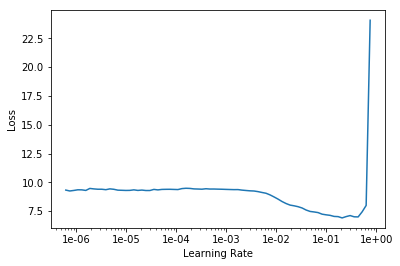

In [36]:
learner.recorder.plot(skip_end=1)

In [38]:
learner.fit_one_cycle(5, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.472726,0.487691,0.693695,00:38
1,0.383621,0.344949,0.583201,00:38
2,0.367073,0.312253,0.553651,00:38
3,0.329585,0.312475,0.553706,00:32
4,0.292369,0.308925,0.550532,00:36


In [40]:
# learner.save('tmp1')

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


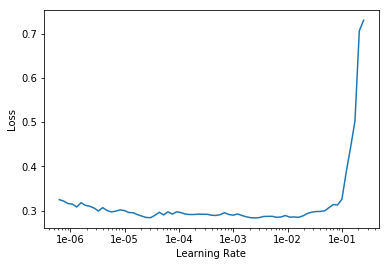

In [41]:
_=learner.load('tmp1')
learner.freeze_to(-2)
learner.lr_find()
learner.recorder.plot(skip_end=1)

In [43]:
_=learner.load('tmp1')
learner.freeze_to(-2)

learner.fit_one_cycle(1, slice(1.5e-03/(2.6**4),1.5e-03), moms=(0.8, 0.7))

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.267487,0.302697,0.544817,00:42


In [45]:
# learner.save('tmp2')

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


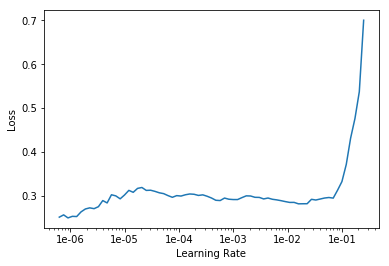

In [46]:
_=learner.load('tmp2')
learner.freeze_to(-3)
learner.lr_find()
learner.recorder.plot(skip_end=1)

In [49]:
_=learner.load('tmp2')
learner.freeze_to(-3)

learner.fit_one_cycle(1, slice(1e-04/(2.6**4),1e-04), moms=(0.8, 0.7))

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.283848,0.304218,0.546063,01:00


In [51]:
learner.save('tmp3')

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


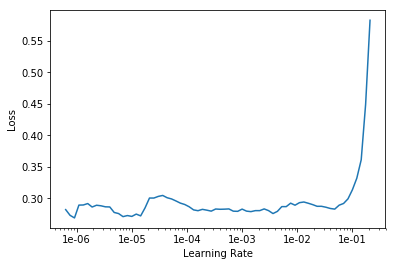

In [52]:
_=learner.load('tmp3')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(skip_end=1)

In [53]:
_=learner.load('tmp3')
learner.unfreeze()

learner.fit_one_cycle(5, slice(3e-05/(2.6**4),3e-05), moms=(0.8, 0.7))

/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/quantran/anaconda3/envs/python37/lib/python3.7/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.276193,0.307753,0.549099,01:18
1,0.284283,0.306177,0.547790,01:31
2,0.268361,0.301729,0.543903,01:33
3,0.272800,0.302849,0.545007,01:28
4,0.287973,0.306682,0.548176,01:34


In [18]:
# # train on all data from training. Took a whole night
# learn.fit_one_cycle(6,max_lr=1e-02,pct_start=0.3,moms=(0.8,0.7))a

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.308574,0.297962,0.543225,1:08:28
1,0.322636,0.325656,0.565951,1:08:32
2,0.308093,0.320362,0.561940,1:08:28
3,0.301868,0.287178,0.532738,1:08:28
4,0.287716,0.280896,0.527114,1:08:32
5,0.283715,0.277816,0.523942,1:08:35


Better model found at epoch 0 with root_mean_squared_error value: 0.543224573135376.
Better model found at epoch 3 with root_mean_squared_error value: 0.5327377915382385.
Better model found at epoch 4 with root_mean_squared_error value: 0.5271139144897461.
Better model found at epoch 5 with root_mean_squared_error value: 0.5239419341087341.
